# CIFAR10 Image Classification

### Dataset
The dataset consists of 10 classes of 32x32 images with three RGB channels.

Tutorial: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html


### Model

**Architecture**
- The model architecture consists of two convolutional layers followed by two fully connected layers and then a linear transformation layer to produce logits, for a total of about 10^6 parameters.
- FedSGD uses a learning-rate decay of 0.9934 per round; FedAvg uses B = 50, learning-rate decay of 0.99 per round, and E = 5.

**FL Setting**
- There are 50,000 training examples and 10,000 testing examples, which we partitioned into 100 clients each containing 500 training and 100 testing examples.
- Since there isn’t a natural user partitioning of this data, we considered the balanced and IID setting.
- The images are preprocessed as part of the training input pipeline, which consists of cropping the images to 24x24, randomly flipping left-right and adjusting the contrast, brightness and whitening.

**Result**

- FedAvg achieves a similar test accuracy of 85% after only 2,000 communication rounds.

In [ ]:
%matplotlib inline
import torch
from torchvision import datasets, transforms
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(42)
np.random.seed(42)


In [ ]:
# Step_00. load data
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, shuffle=True, num_workers=2)

testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

train_idcs, test_idcs = np.arange(len(trainset)), np.arange(len(testset))
train_labels = np.asarray(trainset.targets)


Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# Step_01. only iid
from data_utils import iid_partition, CustomSubset
num_clients = 100
client_iid_idcs = [list(range(i * len(trainset) // num_clients, (i + 1) * len(trainset) // num_clients)) for i in range(num_clients)]
client_iid_data = [CustomSubset(trainset, idcs) for idcs in client_iid_idcs]

test_data = CustomSubset(testset, test_idcs, transforms.Compose([transforms.ToTensor()]))


In [ ]:
train_labels[client_iid_idcs]

array([[6, 9, 9, ..., 0, 1, 7],
       [5, 8, 2, ..., 1, 3, 5],
       [9, 4, 3, ..., 2, 7, 3],
       ...,
       [8, 2, 4, ..., 4, 9, 3],
       [8, 9, 4, ..., 0, 0, 3],
       [3, 8, 9, ..., 9, 1, 1]])

In [ ]:
train_labels[client_iid_idcs].shape

(100, 500)

In [ ]:
# Step_04. Build models
import torch.nn as nn
import torch.nn.functional as F

class CNNCifar(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x



In [ ]:
# FL_settings
from fl_devices import Server, Client

batch_size = 64

cnn_iid_clients = [Client(CNNCifar, lambda x : torch.optim.SGD(x, lr=0.01), dat, idnum=i, batch_size = batch_size
)
           for i, dat in enumerate(client_iid_data)]
cnn_iid_server = Server(CNNCifar, test_data)


In [ ]:
# Step_05. Training on iid data
from helper import ExperimentLogger, display_train_stats

def fl_train(server, clients, pct_participant=0.1, num_local_epochs=1, max_rounds=100, target_accuracy=0.97):
    cfl_stats = ExperimentLogger()

    for c_round in range(1, max_rounds+1):

        if c_round == 1:
            for client in clients:
                client.synchronize_with_server(server)

        participating_clients = server.select_clients(clients, frac=pct_participant)

        for client in participating_clients:
            train_stats = client.compute_weight_update(epochs=num_local_epochs)
            client.reset()

        server.aggregate_weight_updates(participating_clients)

        acc_clients = [client.evaluate() for client in clients]

        cfl_stats.log({"acc_clients" : acc_clients, "rounds" : c_round})

        title = f"C={pct_participant}, E={num_local_epochs}"

        display_train_stats(cfl_stats, max_rounds, title=title, target_accuracy=target_accuracy)

        return cfl_stats


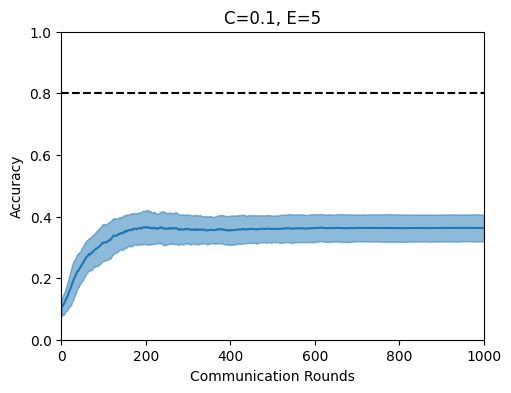

In [ ]:
fl_train(cnn_iid_server, cnn_iid_clients, num_local_epochs=5, max_rounds=1000, target_accuracy=0.8)